# Clustering: Density - OPTICS

## References

https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data?select=Country-data.csv

## Import Python Libraries

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.utils import resample

## Global Variables

In [118]:
# random state 
random_state = 4781

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black
c6 = ["#fbfce6", "#a2daf2", "#ffc7c7", '#8e6a9e']
c7 = [(0, 0, 1), (0, 1 ,0), (1, 0, 0), (1, 1, 0)]
c8 = ['#757272', '#fcba03', '#0367fc', '#9003fc', '#fc3503', '#524e4d', '#35dbc0']

## Import Dataset

In [119]:
# Source: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data?select=Country-data.csv

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: country	Name of the country
# X02: child_mort	Death of children under 5 years of age per 1000 live births
# X03: exports	Exports of goods and services per capita. Given as %age of the GDP per capita
# X04: health	Total health spending per capita. Given as %age of GDP per capita
# X05: imports	Imports of goods and services per capita. Given as %age of the GDP per capita
# X06: Income	Net income per person
# X07: Inflation	The measurement of the annual growth rate of the Total GDP
# X08: life_expec	The average number of years a new born child would live if the current mortality patterns are to remain the same
# X09: total_fer	The number of children that would be born to each woman if the current age-fertility rates remain the same.
# X10: gdpp	The GDP per capita. Calculated as the Total GDP divided by the total population.

In [120]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/country_data.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [121]:
# identify X_cols
X_cols = df0.columns
X_cols

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [122]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

X_cols = ['X' + i.zfill(zeros) for i in temp]
df1.columns = X_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [123]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     167 non-null    object 
 1   X02     167 non-null    float64
 2   X03     167 non-null    float64
 3   X04     167 non-null    float64
 4   X05     167 non-null    float64
 5   X06     167 non-null    int64  
 6   X07     167 non-null    float64
 7   X08     167 non-null    float64
 8   X09     167 non-null    float64
 9   X10     167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [124]:
# describe data
df1.describe()

,X02,X03,X04,X05,X06,X07,X08,X09,X10
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [125]:
# check missing values
df1.isna().sum()

X01    0
X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
dtype: int64

In [126]:
# encode categorical values to numerical values
le = LabelEncoder()

categorical_cols = df1[X_cols].select_dtypes("object").columns
df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10
0,0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Data Cleaning and Transformation

In [127]:
# drop useless columns
drop_id = ['X01']
df1 = df1.drop(columns = drop_id, errors = 'ignore')

df1.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [128]:
# predictor columns
X_cols = df1.columns
X_cols

Index(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10'], dtype='object')

In [129]:
# remove rows with missing valus
for X in df1.columns:
  cond1 = ~((df1[X].isna()))
  df1 = df1.loc[cond1,:]
  
df1.isna().sum()

X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
dtype: int64

In [130]:
# define X (feature matrix)
X_cols = df1.columns
X = df1[X_cols]
X.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [131]:
# # transform specific columns
# for X in df1.columns:
#   a = np.abs(df1[X].min()) + 1 + df1[X]
#   df1[X] = np.log(a)
  
#   df1[X]

In [132]:
# normalize all X_cols
df2 = df1.copy()
norm = StandardScaler()
# norm = MinMaxScaler()
# norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


In [133]:
# # inital row count
# n0 = df2.shape[0]

# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]

# # new row count
# n1 = df2.shape[0]

# # rows removed
# print('Rows removed = %d \n' %(n0-n1))
# df2.info()

## Visualize Dataset

In [134]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
palette2 = [c3, c4]
figsize = (15, 15)

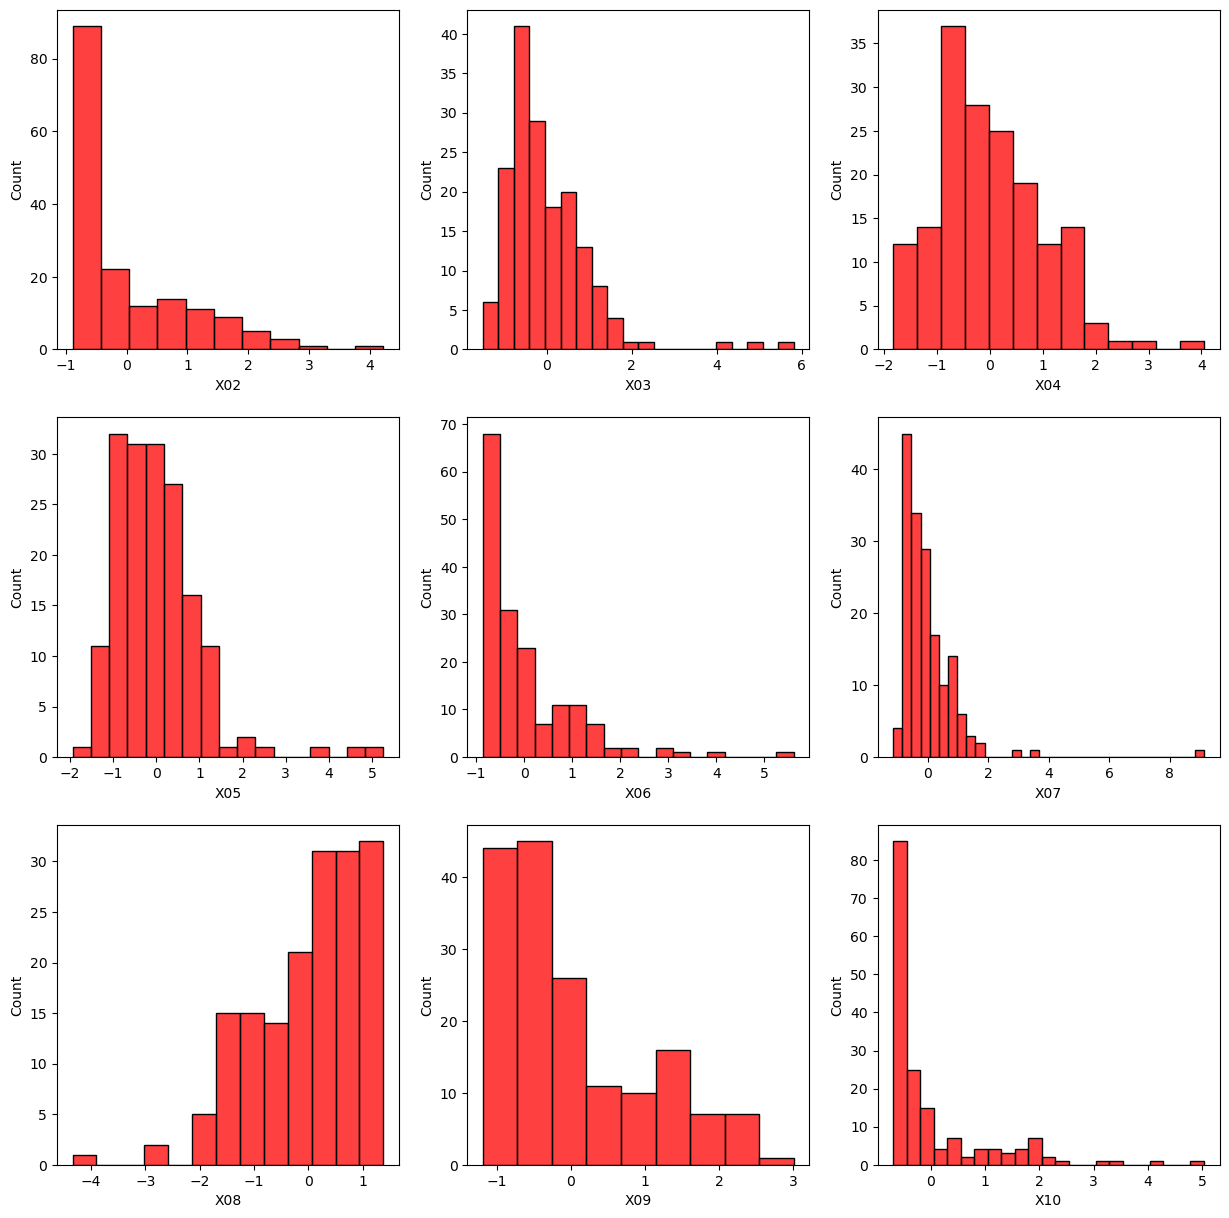

In [135]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  p1 = sns.histplot(ax = axes[row, col], data = df2, x = x, color = c2, linewidth = 1)
  axes[row, col].legend_ = None
  itr = itr + 1

## Train and Test ML Model

In [136]:
# define X - feature matrix
X = df2[X_cols]
X.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


In [137]:
# split data into train and test datasets
X_train, X_test = train_test_split(X,
  train_size = 0.7, random_state = random_state
)

In [138]:
# get principal components
pca = PCA(n_components = 2)

In [139]:
# fit principal components to training data
temp = pca.fit(X_train)

In [140]:
# pca explained variance ration
var_ratio = pca.explained_variance_ratio_
var_ratio.sum()

0.6714547276010572

In [141]:
# transform data based on principal components
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X = pca.transform(X)

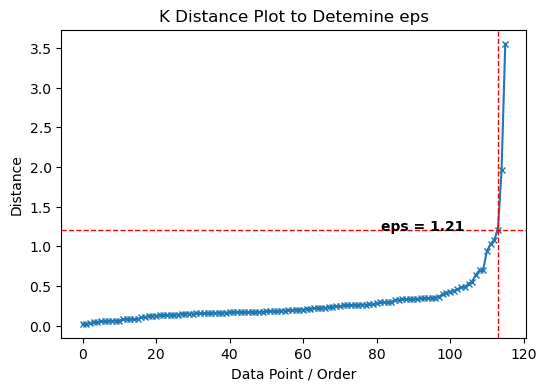

In [288]:
# determine optimal eps neighborhood value using k-distance
nn = NearestNeighbors(n_neighbors = 2)
temp = nn.fit(X_train)
distances, indicies = nn.kneighbors(X_train)
distances = np.sort(distances[:,1])
change_points = zip(distances[:-1], distances[1:])
distance_changes = [np.abs(b-a) for a, b, in change_points]
max_change = np.max(distance_changes)
cond = np.where(distance_changes == max_change)[0] - 1
eps = distances[cond][0]

# plot optimal eps determination
fig, axes = plt.subplots(figsize = (6,4))
plt.plot(distances, marker = 'x',markersize = 5)
plt.title('K Distance Plot to Detemine eps')
plt.xlabel('Data Point / Order')
plt.ylabel('Distance')
x_max = len(distances)
y_max = np.max(distances)
plt.text(x = 0.7 * x_max, y = eps, 
         s = 'eps = %s' %(eps.round(2)), 
         fontweight = 'bold'
)
plt.axhline(y = eps, color = c2, linestyle = '--', linewidth = 1)
plt.axvline(x = cond, color = c2, linestyle = '--', linewidth = 1)
plt.show()

In [289]:
# use density based - defined distance (dbscan) to generate clusters
clustering_model = OPTICS(
  eps = eps,
  cluster_method = 'xi',
  # cluster_method = 'dbscan',
  # metric = 'l2',
  # metric = 'cityblock',
  metric = 'manhattan',
  # metric = 'euclidean',
  min_cluster_size = 0.8 #assume 20% possible outliers
)

In [290]:
# help(OPTICS)

In [291]:
# function to plot clusters
def jra_plot_clusters(X, clustering_model, title):
  
  # fit clustering model
  temp = clustering_model.fit(X)
  
  # get predicted labels
  y_hat = clustering_model.labels_.tolist()

  # initialize plot paramaters
  X1_values = X[:, 0]
  X2_values = X[:, 1]
  X1_min = X1_values.min() - 1
  X2_min = X2_values.min() - 1
  X1_max = X1_values.max() + 1
  X2_max = X2_values.max() + 1

  # plot clusters
  k = len(np.unique(clustering_model.labels_))
  sns.scatterplot(x = X1_values, y = X2_values, hue = y_hat, palette = c8[0:k], s = 35)
  plt.title(title)
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  # plt.show()

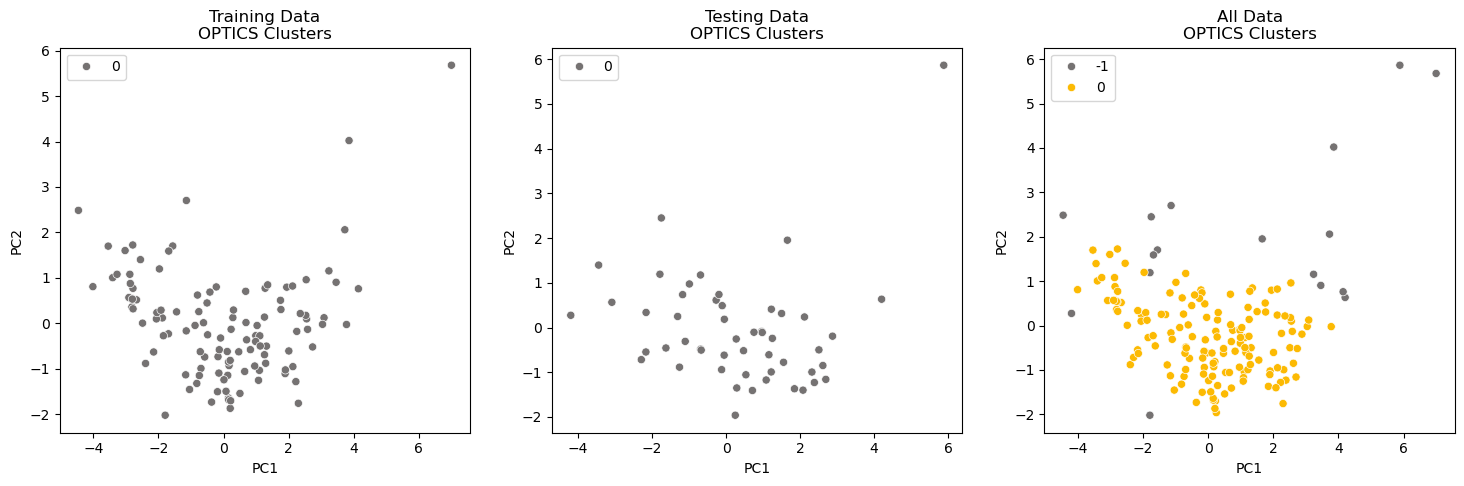

In [292]:
# plot clusters
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 5))

# training data clusters
title = 'Training Data\nOPTICS Clusters'
plt.subplot(131)
jra_plot_clusters(X_train, clustering_model, title)

# # testing data clusters
title = 'Testing Data\nOPTICS Clusters'
plt.subplot(132)
jra_plot_clusters(X_test, clustering_model, title)

# # all data clusters
title = 'All Data\nOPTICS Clusters'
plt.subplot(133)
jra_plot_clusters(X, clustering_model, title)